<a href="https://www.kaggle.com/code/mdrejwanurrahman/notebook8640634a91?scriptVersionId=194718787" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [145]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import joblib

In [146]:

print("TensorFlow version:", tf.__version__)
print("TensorFlow Probability version:", tfp.__version__)

TensorFlow version: 2.16.1
TensorFlow Probability version: 0.24.0


In [147]:
# Choose the filename of the uploaded file
filename = '/kaggle/input/canada/AUG21_2023_BD81_bLog05F2-1deceleration_profile.txt'
# Load the text file containing depth vs. deceleration values
data = np.loadtxt(filename)
depth = data[:, 0]
deceleration = data[:, 1]

In [148]:
depth

array([0.    , 0.0016, 0.0033, 0.0049, 0.0065, 0.0082, 0.0098, 0.0114,
       0.013 , 0.0147, 0.0163, 0.0179, 0.0196, 0.0212, 0.0228, 0.0244,
       0.0261, 0.0277, 0.0293, 0.031 , 0.0326, 0.0342, 0.0358, 0.0375,
       0.0391, 0.0407, 0.0423, 0.044 , 0.0456, 0.0472, 0.0488, 0.0504,
       0.0521, 0.0537, 0.0553, 0.0569, 0.0585, 0.0601, 0.0617, 0.0633,
       0.065 , 0.0666, 0.0682, 0.0698, 0.0714, 0.073 , 0.0746, 0.0761,
       0.0777, 0.0793, 0.0809, 0.0825, 0.0841, 0.0857, 0.0872, 0.0888,
       0.0904, 0.092 , 0.0935, 0.0951, 0.0967, 0.0982, 0.0998, 0.1013,
       0.1029, 0.1044, 0.106 , 0.1075, 0.1091, 0.1106, 0.1121, 0.1137,
       0.1152, 0.1167, 0.1182, 0.1197, 0.1213, 0.1228, 0.1243, 0.1258,
       0.1273, 0.1288, 0.1303, 0.1318, 0.1332, 0.1347, 0.1362, 0.1377,
       0.1391, 0.1406, 0.1421, 0.1435, 0.1449, 0.1464, 0.1478, 0.1492,
       0.1507, 0.1521, 0.1535, 0.1549, 0.1563, 0.1577, 0.1591, 0.1604,
       0.1618, 0.1631, 0.1645, 0.1658, 0.1671, 0.1685, 0.1698, 0.1711,
      

In [149]:
# Create an interpolation function
interpolation_function = interp1d(depth, deceleration, kind='nearest')

# Define the depth intervals at 0.01 m increments
depth_interpolated = np.arange(min(depth), max(depth), 0.01)

# Use the interpolation function to get deceleration values at these intervals
deceleration_interpolated = interpolation_function(depth_interpolated)



In [150]:
deceleration_interpolated

array([0.    , 0.0328, 0.0822, 0.1622, 0.2819, 0.4266, 0.5821, 0.7696,
       0.9075, 1.0354, 1.1571, 1.2879, 1.3926, 1.5422, 2.0729, 2.7536,
       3.3093, 3.6507, 4.0203, 4.3952, 4.8499, 5.2552, 5.5335, 5.5699,
       4.5021])

In [151]:

# Define the desired shape (211,)
desired_shape = (211,)

# Calculate the number of zeros needed to pad
zeros_to_add = desired_shape[0] - deceleration_interpolated.shape[0]

# Pad the original array with zeros to achieve the desired shape
padded_array = np.pad(deceleration_interpolated, (0, zeros_to_add), 'constant')
padded_array=padded_array.reshape(1,211)

In [152]:
padded_array.shape

(1, 211)

In [154]:

# Load the saved model
loaded_rf_model = joblib.load('/kaggle/input/randomfor/scikitlearn/default/1/random_forest_model.joblib')

# Now 'loaded_rf_model' contains the Random Forest model, and you can use it for predictions.
max_dec = np.max(padded_array, axis=1)
pd = np.count_nonzero(padded_array, axis=1)
predRF=np.column_stack((max_dec,pd))
class_probs = loaded_rf_model.predict_proba(predRF)

In [155]:
import sklearn
import joblib

print('scikit-learn version:', sklearn.__version__)
print('joblib version:', joblib.__version__)


scikit-learn version: 1.2.2
joblib version: 1.4.2


In [156]:
class_probs

array([[0.08, 0.77, 0.13, 0.02]])

In [157]:
# Original array with 4 values that sum up to 1
original_array = np.array(class_probs)

# Calculate the sum of the original array
original_sum = np.sum(original_array)

# Scale the array to sum up to 0.6
desired_sum = 0.6
pad=0.1
scaled_array = (original_array / original_sum) * desired_sum
prior=scaled_array+pad
print(prior)
classes = ['Class 1','Class 2','Class 3','Class 4']
# plt.bar(classes,np.squeeze(prior))

[[0.148 0.562 0.178 0.112]]


In [158]:
# Load the saved model

# from tensorflow.keras.models import load_model
# loaded_model = tf.saved_model.load('/content/drive/MyDrive/Journal Paper 1/main_folder')

scaler = joblib.load('/kaggle/input/pffp_bnn2/tensorflow2/default/1/scaler_fit.joblib')
padded_array=padded_array*100/5.61
pred_in_scaled = scaler.transform(padded_array.reshape(-1, 1)).reshape(padded_array.shape)
pred_in_scaled = np.reshape(pred_in_scaled,[pred_in_scaled.shape[0],pred_in_scaled.shape[1],1])
# likelihood=loaded_model.predict(pred_in_scaled)


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [159]:
import tensorflow as tf
import tensorflow_probability as tfp

# Define the kernel divergence function
def kernel_divergence_fn(q, p, _):
    return tfp.distributions.kl_divergence(q, p) / 909.0

# Model building
class BayesianConv1DModel(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.conv1 = tfp.layers.Convolution1DFlipout(32, kernel_size=3, activation='relu', 
                                                     kernel_divergence_fn=kernel_divergence_fn, 
                                                     padding='VALID')
        self.conv2 = tfp.layers.Convolution1DFlipout(64, kernel_size=3, activation='relu', 
                                                     kernel_divergence_fn=kernel_divergence_fn, 
                                                     padding='VALID')
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tfp.layers.DenseFlipout(1024, activation='relu', kernel_divergence_fn=kernel_divergence_fn)
        self.dense2 = tfp.layers.DenseFlipout(64, activation='relu', kernel_divergence_fn=kernel_divergence_fn)
        self.dense3 = tfp.layers.DenseFlipout(4, activation='softmax', kernel_divergence_fn=kernel_divergence_fn)

    def __call__(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return x

# Instantiate the model
model = BayesianConv1DModel()

# Define loss function
def loss_fn(labels, predictions):
    return tf.reduce_mean(tf.keras.losses.categorical_crossentropy(labels, predictions))

# Define the training step
def train_step(model, inputs, labels, optimizer):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = loss_fn(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# # Example training loop
# optimizer = tf.keras.optimizers.Adam()
# for epoch in range(epochs):
#     for inputs, labels in dataset:
#         loss = train_step(model, inputs, labels, optimizer)
#     print(f"Epoch {epoch}, Loss: {loss.numpy()}")

In [160]:
import numpy as np

# Function to predict new data
def predict(model, new_data):
    """
    Generates predictions from the model for the given new data.

    Args:
    model: The trained Bayesian neural network model.
    new_data: A NumPy array or a TensorFlow tensor of new data to predict.

    Returns:
    A NumPy array of predictions.
    """
    # Ensure the input is a TensorFlow tensor
    new_data = tf.convert_to_tensor(new_data, dtype=tf.float32)

    # Perform a forward pass and obtain the logits
    logits = model(new_data)

    # Since the last layer uses softmax, the output will be the probabilities
    probabilities = tf.nn.softmax(logits)

    # Optionally, you can obtain the class predictions directly
#     class_predictions = tf.argmax(logits, axis=1)

    return probabilities.numpy()  # Convert probabilities to NumPy array for easier handling

# Example usage
# Assuming `X_new` is your new dataset ready to be predicted
# X_new = np.random.random((10, sequence_length, channels))  # Dummy data for illustration
# predictions = predict(model, X_new)
# print(predictions)

In [161]:
modelcp2 = BayesianConv1DModel()

checkpoint2 = tf.train.Checkpoint(model=modelcp2)

checkpoint2.restore('/kaggle/input/pffp_bnn2/tensorflow2/default/1/copsave-1')


In [162]:
# Example usage
# Assuming `X_new` is your new dataset ready to be predicted
# X_new = np.random.random((10, sequence_length, channels))  # Dummy data for illustration
predictions = predict(modelcp, pred_in_scaled)
class_predictions = tf.argmax(predictions, axis=1)
print(predictions)
print(class_predictions)

[[0.18049017 0.46722987 0.17613831 0.17614166]]
tf.Tensor([1], shape=(1,), dtype=int64)


In [163]:
predictions*prior/np.sum(predictions*prior)

array([[0.07847947, 0.77144987, 0.09211166, 0.057959  ]])

/opt/conda/lib/python3.10/site-packages/tensorflow_probability/python/layers/util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/opt/conda/lib/python3.10/site-packages/tensorflow_probability/python/layers/util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Text(0.5, 0, 'Deceleration[g]')

<Figure size 640x480 with 0 Axes>

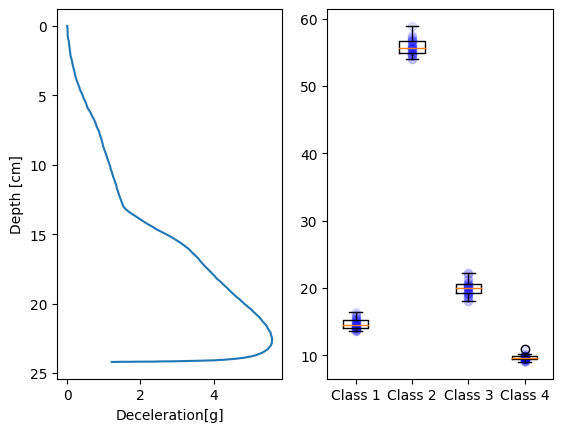

In [164]:
ss =[]
# n= int(input())


c = [1,2,3,4]
plt.figure()
fig, ax = plt.subplots(1,2)

for i in range(0,30):
  s = predict(modelcp2, pred_in_scaled)
  post=((prior)*s)
  final_s = 100*post/np.sum(post)
  ss.append(final_s)
  ax[1].scatter(c,final_s,c="blue",alpha=0.1)
# ss=np.array(ss)
# sss = pd.DataFrame(np.squeeze(ss))
sss = np.squeeze(ss)
ax[1].boxplot(sss)
ax[1].set_xticklabels(classes)
# ax[1].set_ylim([0, 20]) 

# ax[1].text(1.8, -0.25, 'Actual Result: Class '+str(y_train[n]+1), color='red')


ax[0].plot(deceleration,depth*100, label=filename)
ax[0].invert_yaxis()
ax[0].set_ylabel("Depth [cm]")
ax[0].set_xlabel("Deceleration[g]")